In [17]:

import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
plot_style()
%matplotlib inline


In [267]:
vls

{-7833058418700047792: 163726085.0887951,
 -8916606884568862373: 42373772555.15901,
 -1157388260220243720: 547406767.0434071,
 -4952161884779639720: 119524173.10857813,
 -2027914736025926131: 5071270862.040211,
 4869388031868703672: 55419475.418291375,
 -2117205915791536138: 90794613.32400398,
 -3679430183484389337: 77579353.59506385,
 -6434444483769932930: 3717077749.01776,
 -4663017697723294271: 75982511.41166133,
 -7327075773181824145: 95502255.57969405,
 8830353258045597986: 915374116.4881291,
 -4334449906487463677: 237175142.10231468,
 -5353205389775112666: 1367476126.176405,
 -7905183995821620201: 299756789.198512,
 6496744443446715672: 15352189936.636148,
 -3107130581421233038: 195737912.77742568,
 8546907196196289467: 63653807.41174294,
 -1167461578265048874: 4340967613.33008,
 -5889258933572875430: 157394137.13932958,
 4559885780806484755: 379176642.854012,
 6373013677238156710: 64497100.87927375,
 152430669752226551: 91067405.39237118,
 5762491009753285707: 82076796.5476118,


In [ ]:
df.

In [266]:
survey='Rubin Wide'
filename=FILENAMES[survey]
data=np.array(np.load('../simulations{}.npy'.format(filename), allow_pickle=True)).flatten()[0]
df= data['data']

vls=data['volume']['thin_disk'][0]
for g in df.groupby(['l', 'b']):
    df.
    try:
        vls[k]
    except:
        print(k)

-5891028082445585490
-8828304546819635240
4727120796641498304
8346475633164259597
2903955080449883926
7853851810966473813
-7236684603592827078
6511602813722125045
4002951201478906304
-7047567578708165479
6839740132014056600
1590081653153499508
4095325741493825429
4453665490105964449
5004867312571922048
6407370230914068611
-6045651467615149735
8265882400482544321
2330738025570382866
-1516417534948027663
-7025782147270137839
2152361713875635339
8322606482062402618
-3722528739938728321
2078331561387786370
-6504782755124387705
-703922453797873014
-2839444550211682187
-6135398288264135117
5346646318577365231
-7299237453805671694
-6497483085845431117
-696622784518916426
1449944030143006315
1688607782943616301
8291222452230371569
-1047662863852098858
-4351402747821844926
5469473401359245552
3704885685435802989
2914176035723675980
-6112352900136599652
9011053036425000896
-2890429314571995691
-5303298862897402487
-7426226327432984070
6980500111904338438
7721156484321221796
4397818347173270728
4

In [37]:
AREA=18_000*u.degree**2

#filenames
FILENAMES={
       'Rubin Wide': 'rubin_wide',
       'Roman HLWAS': 'roman_hlwas',
       'Roman HLTDS': 'roman_hltds',
       'Roman GBTDS': 'roman_gbtds',
       'Euclid Wide': 'euclid_wide',
       'Rubin Deep': 'rubin_deep',
       'Euclid Deep': 'euclid_deep',
       'JWST PASSAGE': 'jwst_passage',
       'JWST JADES': 'jwst_jades',
       'JWST CEERS':  'jwst_ceers',
       'JWST NGDEEP': 'jwst_ngdeep'
}


In [160]:
data['mag_limits']

{'LSST_G': 25.0,
 'LSST_R': 24.7,
 'LSST_I': 24.0,
 'LSST_Z': 23.3,
 'LSST_Y': 22.1}

In [169]:
hash(0.40000)==hash(0.4000)

True

922337203685477632

-4218814906537062052
-121950874969927969
70911198883890610
7274274418552551864
3135500853414690142
-5891028082445585490
-4488525164103438927
1312335137223075764
8708560430745555597
8215936608547769813
-8828304546819635240
-3027444245493120549
-1266601578538834966
-8277102724353677641
-6874599806011531078
-1073739504685016387
4727120796641498304
6392770892356155435
-4850609961684734927
6751110640968294455
8153613559310441018
8346475633164259597
-4299408139218777328
2903955080449883926
8704815381776398617
7853851810966473813
-9190389344400931240
-3389529043074416549
2411331258252098142
-8832049595788792220
-1435824302266312387
5767538917402348867
710742512395610354
6511602813722125045
7914105732064271608
-4731778040318765317
2471585179349895937
8272445480676410628
1690906712058663122
7491767013385177813
8894269931727324376
-3751613840655712549
-2156248848459747407
-9001272319516269641
-7598769401174123078
4002951201478906304
5405454119821052867
-7405907327320304499
-1605047025993789808
-

In [105]:
def compute_vols_and_numbers(df,  sptgrid):
    counts={}
    for spt in sptgrid:
        scale=[df.scale.mean(), df.scale_unc.mean(), df.scale_times_model.mean()]
        sn= len(df)
        sn_c= len(df.query('spt < {}'.format(spt, spt+0.9)))
        #add a selection function by pointing i.e 
        cnts={'number':  sn_c*np.divide(scale[-1], sn)}
        counts.update({spt: cnts})
    return pd.DataFrame.from_records(counts).T.replace(np.inf, np.nan)


def get_numbers(survey):
    filename=FILENAMES[survey]
    data=np.array(np.load('../simulations{}.npy'.format(filename), allow_pickle=True)).flatten()[0]
    df= data['data']
    drho=(SURVEY_AREAS[survey]/len(data['footprint'])).to(u.radian**2)
    sptgrid=data['sptgrid']
    ns_df={'thin_disk': [], 'thick_disk': [], 'halo': []}
    for k in ns_df.keys():
        k2=k
        if k in ['thin_disk', 'thick_disk']:
            #so dumb
            f=lambda x: x[0]+' '+ x[1]; k2=f(k.split('_'))
        ns_df[k]=compute_vols_and_numbers(df[df.population==k2],  \
                                 sptgrid).number.values*data['volume'][k]*drho
    ns_df['spt']=sptgrid
    
    return pd.DataFrame(ns_df), data['volume']
    
    

In [ ]:
#LOAD DP0 data
#dp0_data=pd.read_csv('/Volumes/lacie/popsimsdata/cone_search.csv')


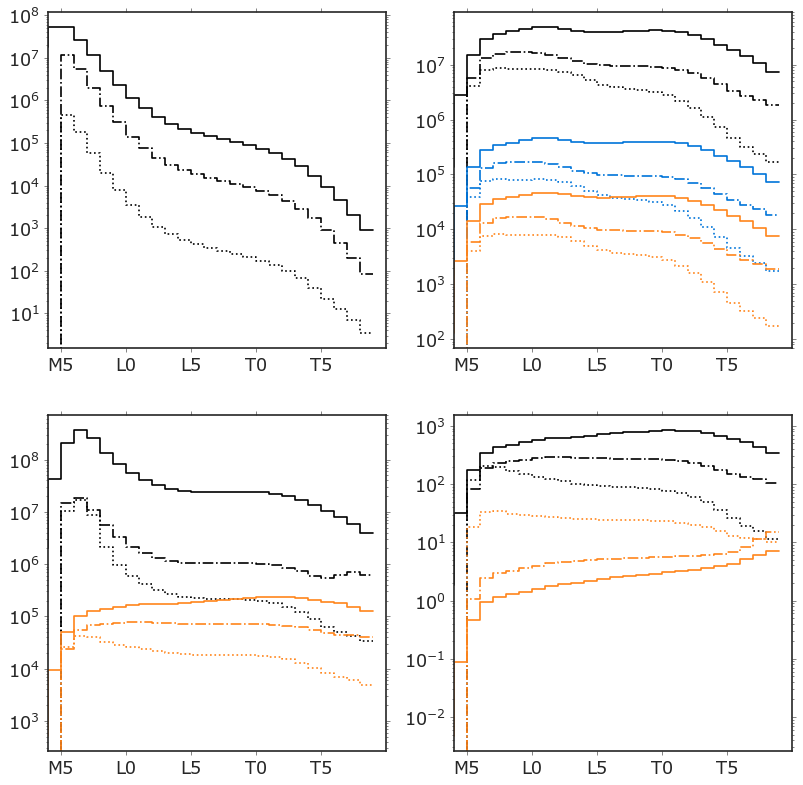

In [106]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

#Rubin
ns=get_numbers('Rubin Wide')[0]
ax[0][0].step(ns.spt, ns.thin_disk, linestyle='-', c='k')
ax[0][0].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.', c='k')
ax[0][0].step(ns.spt, 0.005*ns.halo, linestyle='dotted', c='k')
for a in np.concatenate(ax):
      a.set(yscale='log')
        
        
#Roman
ns=get_numbers('Roman HLWAS')[0]
ax[0][1].step(ns.spt, ns.thin_disk, linestyle='-', c='k')
ax[0][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.', c='k')
ax[0][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted', c='k')
for a in np.concatenate(ax):
      a.set(yscale='log')

#Roman
ns=get_numbers('Roman HLTDS')[0]
ax[0][1].step(ns.spt, ns.thin_disk, linestyle='-', c='#0074D9')
ax[0][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.', c='#0074D9')
ax[0][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted', c='#0074D9')
for a in np.concatenate(ax):
      a.set(yscale='log')
        
        
#Roman
ns=get_numbers('Roman GBTDS')[0]
ax[0][1].step(ns.spt, ns.thin_disk, linestyle='-', c='#FF851B')
ax[0][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.', c='#FF851B')
ax[0][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted', c='#FF851B')
for a in np.concatenate(ax):
      a.set(yscale='log')
        
        
#euclid
ns=get_numbers('Euclid Wide')[0]
ax[1][0].step(ns.spt, ns.thin_disk, linestyle='-', c='k')
ax[1][0].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.', c='k')
ax[1][0].step(ns.spt, 0.005*ns.halo, linestyle='dotted', c='k')

#euclid
ns=get_numbers('Euclid Deep')[0]
ax[1][0].step(ns.spt, ns.thin_disk, linestyle='-',c='#FF851B')
ax[1][0].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.',c='#FF851B')
ax[1][0].step(ns.spt, 0.005*ns.halo, linestyle='dotted',c='#FF851B')


#jWST 
ns=get_numbers('JWST PASSAGE')[0]
ax[1][1].step(ns.spt, ns.thin_disk, linestyle='-',c='k')
ax[1][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.',c='k')
ax[1][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted',c='k')

ns=get_numbers('JWST JADES')[0]
ax[1][1].step(ns.spt, ns.thin_disk, linestyle='-',c='#FF851B')
ax[1][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.',c='#FF851B')
ax[1][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted',c='#FF851B')

ns=get_numbers('JWST CEERS')[0]
ax[1][1].step(ns.spt, ns.thin_disk, linestyle='-',c='#FF851B')
ax[1][1].step(ns.spt, 0.12*ns.thick_disk, linestyle='-.',c='#FF851B')
ax[1][1].step(ns.spt, 0.005*ns.halo, linestyle='dotted',c='#FF851B')

for a in np.concatenate(ax):
    a.set(xticks=[15,20, 25, 30, 35], xticklabels=['M5', 'L0', 'L5', 'T0', 'T5'],\
          xlim=[14, 40], yscale='log')
        

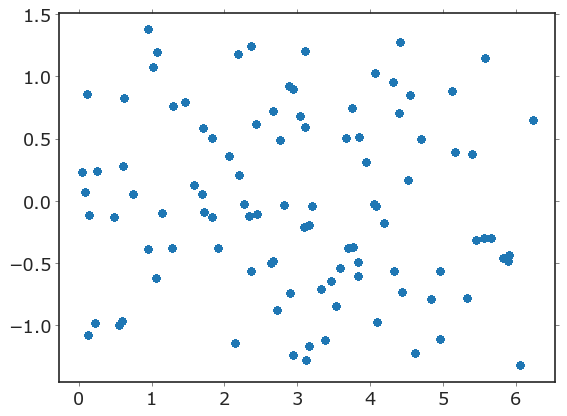

In [155]:
fig, ax=plt.subplots()
ax.scatter(df.l, df.b, alpha=0.1)

In [143]:
f= (124*4*u.arcmin**2)/ (65*u.arcmin**2) #JADES over PASSAGE


In [145]:
#CONTROL FOR DIFFERENCE IN AREA
ns=get_numbers('JWST PASSAGE')

In [146]:
ns1=get_numbers('JWST JADES')

[None]

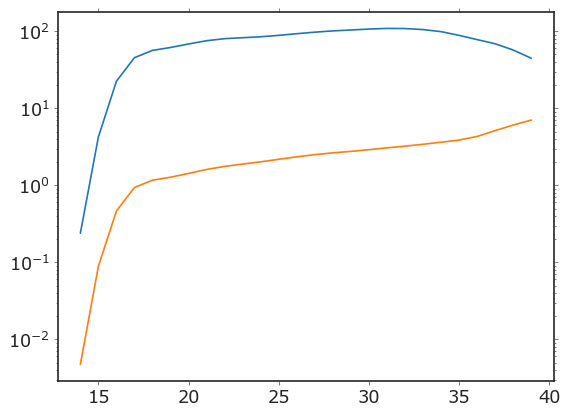

In [149]:
fig, ax=plt.subplots()
plt.plot(sptgrid, ns[0]['thin_disk']/f)
plt.plot(sptgrid, ns1[0]['thin_disk'])

ax.set(yscale='log')


In [144]:
f

<Quantity 7.63076923>

In [6]:
#area

In [22]:
data['volume']['thin_disk']

[665669647321.5032,
 208001423459.01846,
 79774656580.99745,
 31682247695.183926,
 13033045688.330265,
 5604417710.315717,
 2575057145.133899,
 1294629165.1007524,
 723253656.986485,
 450731673.1224464,
 311314171.5791987,
 234851322.8718005,
 189621899.35878643,
 160003248.07086208,
 137536084.05999854,
 117385022.82598864,
 97085242.68466216,
 81516750.14116159,
 64741778.484225646,
 47311727.90717848,
 31410272.140340924,
 18809837.22311132,
 10158553.586608298,
 4988972.586959551,
 2268894.797992233,
 983939.1074966484]

[None]

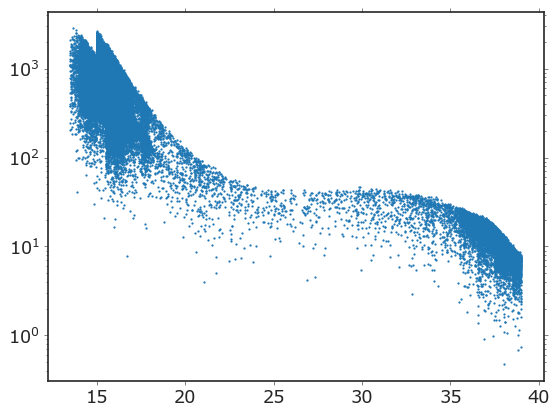

In [8]:
fig, ax=plt.subplots()
ax.scatter(df.spt, df.distance, s=1)
ax.set(yscale='log')

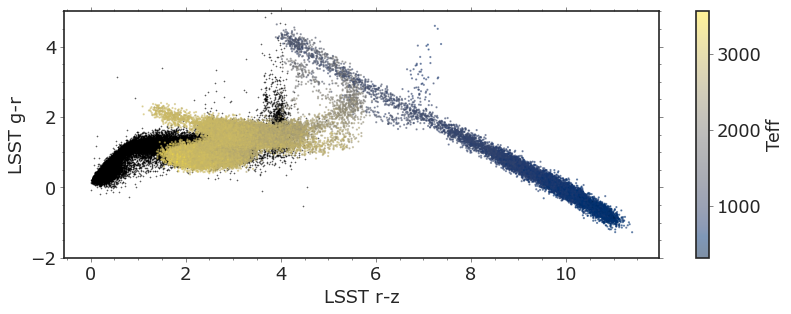

In [11]:
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter( dp0_data.mag_r-dp0_data.mag_z, dp0_data.mag_g-dp0_data.mag_r, color='k', label='DP0 Data', s=.1)
c=ax.scatter( df.LSST_R-df.LSST_Z, df.LSST_G-df.LSST_R,c=df.temperature, cmap='cividis', s=1, alpha=0.5)
plt.colorbar(c, label='Teff')
ax.set(ylabel='LSST g-r', xlabel='LSST r-z', ylim=[-2, 5])
ax.minorticks_on()

plt.savefig('../figures/lsst_color_selections.jpeg', bbox_inches='tight')


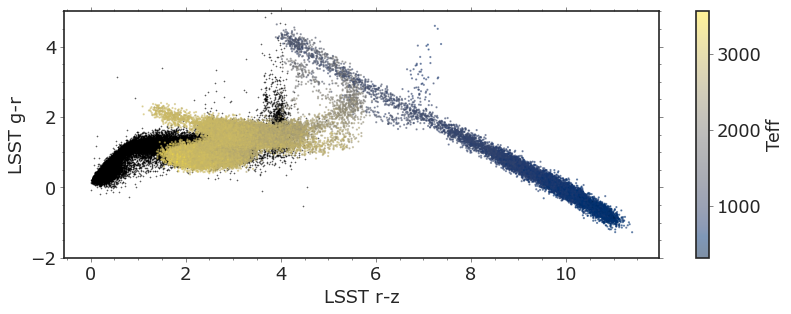

In [ ]:
#other color and